# Dogs vs Cats and the power of transfer learning

The goal of this notebook is to classify whether images contain either a dog or a cat. We will use "transfer learning" 


The data for this competition can be found [here](https://www.kaggle.com/c/dogs-vs-cats).



In [110]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [111]:
import cv2
import matplotlib.pyplot as plt 

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/datasets/kmader/rsna-bone-age/ )<br/>
`kaggle competitions download -d  dogs-vs-cats -p PATH` <br/>

You can also get the data from fast.ai <br/>
`wget http://files.fast.ai/data/dogscats.zip`

In [3]:
PATH = Path("/data2/yinterian/dogscats/")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/dogscats/valid'),
 PosixPath('/data2/yinterian/dogscats/test1'),
 PosixPath('/data2/yinterian/dogscats/sample'),
 PosixPath('/data2/yinterian/dogscats/train'),
 PosixPath('/data2/yinterian/dogscats/models')]

In [4]:
! ls /data2/yinterian/dogscats/train

cats  dogs


In [5]:
! ls /data2/yinterian/dogscats/train/cats | head

cat.0.jpg
cat.10000.jpg
cat.10001.jpg
cat.10002.jpg
cat.10003.jpg
cat.10004.jpg
cat.10005.jpg
cat.10006.jpg
cat.10007.jpg
cat.10008.jpg
ls: write error: Broken pipe


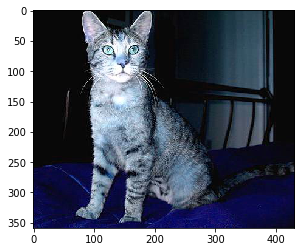

In [6]:
path = PATH/"train/cats/cat.10000.jpg"
im = cv2.imread(str(path))  #.astype(np.float32)/255
plt.imshow(im)

In [7]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(359, 431, 3)

In [8]:
# let's look at the typical size of these images
path = PATH/"train/cats"
files = list(path.iterdir())[:200]
dims = [cv2.imread(str(p)).shape for p in files]
dims[:10]

[(411, 500, 3),
 (374, 500, 3),
 (374, 500, 3),
 (479, 400, 3),
 (349, 400, 3),
 (374, 498, 3),
 (374, 500, 3),
 (431, 288, 3),
 (317, 336, 3),
 (399, 310, 3)]

## Data augmentation
Data augmentation is the most important way to avoid overfitting for image classification tasks.

In [112]:
# modified from fast.ai
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center crop

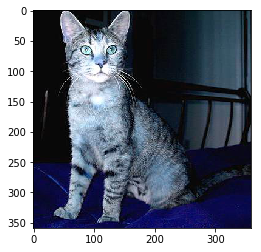

In [113]:
path = PATH/"train/cats/cat.10000.jpg"
im = cv2.imread(str(path))
im = center_crop(im)
plt.imshow(im, cmap='gray')

### Resize, horizontal and vertical translations

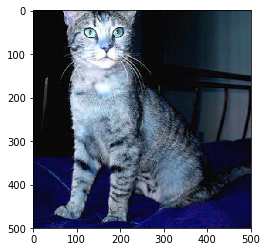

In [11]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
im = cv2.resize(im, (550, 550))
im2 = random_crop(im, 500, 500)
plt.imshow(im2, cmap='gray')

### Random Rotation (-10, 10) 

-6.262002048642503


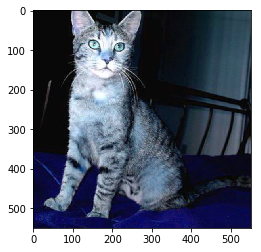

In [12]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot, cmap='gray')

### Horizontal Flip

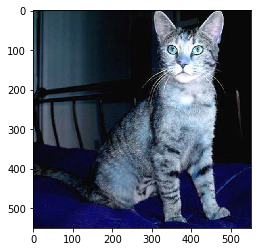

In [13]:
im_f = np.fliplr(im)
plt.imshow(im_f, cmap='gray')

## Dataset

In [114]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [122]:
class DogsCatsDataset(Dataset):
    def __init__(self, PATH, train="train", sz=224):
        self.path_to_images = PATH/train
        self.transforms = False
        if train == "train": self.transforms = True
        self.sz = sz
        self.sz2 = int(sz*1.05)
        self.cats_files = list((self.path_to_images/"cats").iterdir())
        self.dogs_files = list((self.path_to_images/"dogs").iterdir())
        self.files = self.cats_files + self.dogs_files
        # cats 1, dogs, 0
        self.y = np.concatenate((np.ones(len(self.cats_files), dtype=int),
                                np.zeros(len(self.dogs_files), dtype=int)), axis=0)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        path = str(self.files[idx]) 
        x = cv2.imread(str(path)).astype(np.float32)/255
        # center crop
        x = center_crop(x)
        if self.transforms:
            x = cv2.resize(x, (self.sz2, self.sz2))
            x = random_crop(x, self.sz, self.sz)
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy() 
        else:
            x = cv2.resize(x, (self.sz, self.sz))
        # substract numbers from resnet34
        x = normalize(x)
        return np.rollaxis(x, 2), self.y[idx]

In [123]:
train_ds = DogsCatsDataset(PATH, "train")
valid_ds = DogsCatsDataset(PATH, "valid")

In [124]:
len(train_ds)

23000

In [137]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [138]:
# run this multiple times to get different images
x, y = train_ds[0]
#plt.imshow(np.rollaxis(x1, 2), cmap='gray')

In [139]:
x.shape,y

((3, 224, 224), 1)

## Model

In [140]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        #x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        #x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [141]:
model = Net().cuda()

In [142]:
x, y = next(iter(train_dl))

In [143]:
x = x.cuda().float()
y = y.cuda().float()
x.shape

torch.Size([64, 3, 224, 224])

In [131]:
x_features = model.top_model(x)
x_features.shape

torch.Size([64, 512, 7, 7])

In [132]:
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)
x_features_ave.shape

torch.Size([64, 512, 1, 1])

In [133]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([64, 512])

In [134]:
y_hat = model(x)
y_hat.shape

torch.Size([64, 1])

In [145]:
# This loss combines a Sigmoid layer and the BCELoss in one single class. see
# https://pytorch.org/docs/master/nn.html#torch.nn.BCEWithLogitsLoss
F.binary_cross_entropy_with_logits(y_hat, y.unsqueeze(1)).item()

0.6963117122650146

In [144]:
y

tensor([ 0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
         1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,
         1.,  0.,  1.,  1.], device='cuda:0')

## Learning rate finder

In [148]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [149]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x,y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda().float().unsqueeze(1)
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses 

In [150]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl)

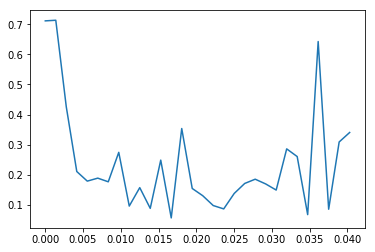

In [153]:
plt.plot(lrs[:30], losses[:30])
plt.show()

## Triangular learning rate training

In [154]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [155]:
def get_triangular_lr2(lr_low, lr_high, stepesize):
    iterations = 2*stepesize
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

In [157]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-5, lr_high=0.01):
    idx = 0
    epochs = 4
    stepesize = 2*len(train_dl)
    lrs = get_triangular_lr2(lr_low, lr_high, stepesize)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().float().unsqueeze(1)
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss", sum_loss/total)
        val_metrics(model, valid_dl)
    return sum_loss/total

In [183]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().unsqueeze(1)
        out = model(x)
        pred = (out > 0.0).long()
        correct += pred.eq(y.data).sum().item()
        y = y.float()
        loss = F.binary_cross_entropy_with_logits(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss and accuracy", sum_loss/total, correct/total)

## Training with triangular rates

In [184]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, steps=3, lr_low=1e-5, lr_high=0.01):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [185]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [186]:
model = Net().cuda()

In [187]:
val_metrics(model, valid_dl)

val loss and accuracy 0.722572783946991 0.455


In [ ]:
training_loop(model, train_dl, valid_dl, steps=1)

train loss 0.12201544895768165
val loss and accuracy 0.06895403057709336 0.9765
train loss 0.0800081446086583
val loss and accuracy 0.048602625664323565 0.982
train loss 0.06160021968688006
val loss and accuracy 0.05114455397613347 0.983


## Unfreezing layers

In [ ]:
def save_model(m, p): 
    torch.save(m.state_dict(), p)
p = PATH/"model.pth"
save_model(model, p)

In [97]:
p = PATH/"model.pth"
model.load_state_dict(torch.load(p))

In [145]:
val_loss(model, valid_dl)

val loss 19.491879188664655


20.56451988220215

In [149]:
p = PATH/"model005.pth"
save_model(model, p)

In [ ]:
# load model
p = PATH/"model005.pth"
model.load_state_dict(torch.load(p))

In [172]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [173]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [175]:
unfreeze(model, 7)

## Testing time augmentation

# References
